# Monte Carlo Simulation 
## for Quantitative Risk Assessment

Reza Darmawan (33462135)<br>
Assignment 1
ITI5057 - Project Management



### A. Import Required Libraried

In [41]:
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### B. Read the dataset

In [101]:
cost_dataset = pd.read_csv('cost_dataset.csv', sep=';')
cost_dataset.head()

,Year,Position,Typical_Salary,Lower_Bound,Upper_Bound,Quantity,Incur_Period,Adjustment_Cost
0,0,System Analyst,700,500,800,1,40,1.115
1,0,Project Manager,900,800,1100,1,40,1.115
2,0,Full Stack Developer (.NET/Java),900,700,1100,1,20,1.115
3,0,Data Engineer,800,650,1050,1,35,1.115
4,0,Data Scientist,1000,800,1300,1,20,1.115


In [102]:
# Calculate current initial project cost given cost dataset and contingency reserve 20% of labor cost
current_initial_cost=1.2*sum([cost_dataset.iloc[a]['Typical_Salary']*cost_dataset.iloc[a]['Quantity']*cost_dataset.iloc[a]['Incur_Period']*cost_dataset.iloc[a]['Adjustment_Cost'] for a in range(len(cost_dataset))])
current_initial_cost

173940.0

### C. Monte Carlo Simulation

In this simulation, I assume 95% confidence interval, which means that the observation is 95% likely to be in between the lower and upper range. It is also assumed that the salary under the defined range follows normal distribution. The standard deviation for the given interval from lower bound $L$ to upper bound $U$ can be calculated as:

$$\sigma=\frac{U-L}{2 \times Z_{\alpha=0.95}}$$

In [116]:
def generate_simulation(typical_cost, lower_limit, upper_limit, n_simulation=700000, confidence=.95):
    '''
    Generate normally distributed simulation given certain typical cost (mean) and cost range

    Keyword arguments:
     - typical_cost: the mean of the cost item
     - lower_limit: the lowest limit on the range
     - upper_limit: the top limit on the range
     - n_simulation: number of simulation to be generated, by default 700K
     - confidence: confidence level that the data is on the defined range

     Return:
     - simulated random variable

    '''
    
    # define Z score for 95% confidence interval
    z_confidence_interval=st.norm.ppf(1-(1-confidence)/2)

    # create normal distribution object with typical cost as mean, and calculated standard deviation
    normal_distribution = st.norm(loc=typical_cost, scale=(upper_limit-lower_limit)/(2*z_confidence_interval))

    # generate random variables simulation
    rv_simulation = normal_distribution.rvs(size=n_simulation)

    # return the simulation
    return rv_simulation 

def cost_overrun_likelihood(monte_carlo_simulation_dataset, accepted_cost_limit):

    '''
    
    '''

    # calculate the probability (likelihood) of cost overrun more than accepted cost limit
    cost_overrun_probability = len(monte_carlo_simulation_dataset[monte_carlo_simulation_dataset['Cost Total']>accepted_cost_limit])/len(monte_carlo_simulation_dataset)

    # print cost overrun likelihood
    print(f'Probability of cost overrun more than the accepted cost limit of AUD{accepted_cost_limit} is {round(cost_overrun_probability*100,4)}%')

    cost_overrun = monte_carlo_simulation_dataset[monte_carlo_simulation_dataset['Cost Total']>accepted_cost_limit]
    print(f"Range of cost overrun: {round(min(cost_overrun['Cost Total']),2)} - {round(max(cost_overrun['Cost Total']),2)}")

    return cost_overrun_probability

def monte_carlo_initial_cost(dataset, cost_item_column, typical_cost_column,
                             lower_limit_column, upper_limit_column,
                             quantity_column, incur_period_column, 
                             adjustment_cost_column, accepted_cost_limit,
                             simulation_label, n_simulation=700000, confidence=.95):
    '''
    Generate normally distributed simulation given dataset containing cost items

    Keyword arguments:
     - dataset: dataset of cost item
     - cost_item_column: the column name that contains cost item identification
     - typical_cost_column: the column name that contains the mean of the cost item
     - lower_limit_column: the column name that contains the lowest limit on the range
     - upper_limit_column: the column name that contains the top limit on the range
     - quantity_column: the column name that contains item quantity of resource
     - incur_period_column: the column name that contains the incur period of the cost
     - adjustment_cost_column: the column name that contains adjustment required e.g. superannuation
     - n_simulation: number of simulation to be generated, by default 700K
     - confidence: confidence level that the data is on the defined range

    Return:
     - dataframe containing simulated cost items
    '''

    # initiate empty dataframe to store simulation data
    simulation_dataframe_column = [dataset.iloc[a][cost_item_column] for a in range(len(dataset))]
    simulation_dataframe = pd.DataFrame(columns=simulation_dataframe_column)

    # iterate over dataframe and generate simulation data 
    for i in range(len(dataset)):
        
        # identify cost item
        cost_item = dataset.iloc[i][cost_item_column]

        # define parameter to generate simulation data
        typical_cost = dataset.iloc[i][typical_cost_column]    # typical cost as mean
        lower_limit = dataset.iloc[i][lower_limit_column]    # lower limit
        upper_limit = dataset.iloc[i][upper_limit_column]    # upper limit

        # generate simulation data
        simulation_data = generate_simulation(typical_cost,lower_limit, upper_limit, n_simulation, confidence)

        # define calculation attribute for cost item
        quantity = dataset.iloc[i][quantity_column]    # quantity
        incur_period = dataset.iloc[i][incur_period_column]    # incur period
        cost_adjustment = dataset.iloc[i][adjustment_cost_column]    # cost adjustment e.g. for superannuation

        # append simulation data to dataframe 
        # after calculating the list with corresponding quantity, incur period, and adjustment
        simulation_dataframe[cost_item] = [i * quantity * incur_period * cost_adjustment for i in simulation_data]
    
    # calculate total initial cost for each simulation
    cost_total = simulation_dataframe.sum(axis='columns')
    simulation_dataframe['Cost Total'] = cost_total

    # Visualize cost simulation distribution
    sns.displot([i/1000 for i in simulation_dataframe["Cost Total"]], 
                kde=True).set(title=f'Monte Carlo Simulation of {simulation_label} ({n_simulation//1000}K simulations)',
                              xlabel='Total Cost (in AUD thousand)')
    plt.axvline(accepted_cost_limit/1000, 0,100,color='red', linestyle='--')
    plt.show()

    # calculate cost overrun probability
    cost_overrun_probability = cost_overrun_likelihood(simulation_dataframe, accepted_cost_limit)

    return simulation_dataframe

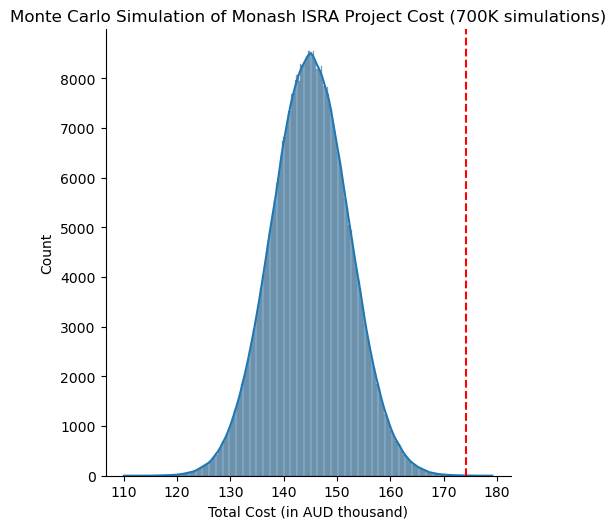

Probability of cost overrun more than the accepted cost limit of AUD174180 is 0.003%
Range of cost overrun: 174300.21 - 179113.63


In [117]:
monte_carlo = monte_carlo_initial_cost(cost_dataset, 'Position', 'Typical_Salary','Lower_Bound', 'Upper_Bound',
                         'Quantity','Incur_Period','Adjustment_Cost', 174180, 'Monash ISRA Project Cost')